In [2]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [3]:
def xgb_model(epochs, objective, booster, max_depth):
    model = XGBRegressor(n_estimators = epochs,
                         max_depth = max_depth,
                         objective = objective,
                         tree_method = 'gpu_hist',
                         booster = booster,
                         verbosity = 1)
    return model


In [4]:
def get_data():
    df = pd.read_excel('~/git/water/Cost-B.xlsx')
    df2 = df.rename({df.columns[0]: 'dirt', df.columns[-1]: 'cost'}, axis=1)
    df2.pop(df.columns[1])
    df = df2.copy()
    data_cost = df.pop('cost')
    label = df.pop('dirt')
    
    # add time msg
    index = list(range(len(df)))
    df['time'] = pd.DataFrame(index)
    
    return df, label

In [5]:
# x = df2.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df2 = pd.DataFrame(x_scaled, columns = df2.columns)
# df2.head()

In [6]:

def data_dec(data):
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    return X_train, X_test, y_train, y_test


In [7]:
def lr_curve(results, ylabel, title):
    keys = list(results.keys())
    item = list(results[keys[0]].keys())[0]
    epochs = len(results[keys[0]][item])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(x_axis, results["validation_0"][item], label="Train")
    ax.plot(x_axis, results["validation_1"][item], label="Test")
    ax.legend()
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


In [8]:
# tree square error

##  gbtree, gblinear or dart
def xgb_test(data2XGB, epochs, plot, objective, booster, max_depth):
    data = data2XGB.copy()
    epochs = epochs
    plot = plot
    objective = objective
    booster = booster
    max_depth = max_depth
    X_train, X_test, y_train, y_test = data_dec(data)

    if plot:
        verbose = 1
    else:
        verbose = 0
    model = XGBRegressor(n_estimators = epochs,
                         max_depth = max_depth,
                         objective = objective,
                         tree_method = 'gpu_hist',
                         booster = booster,
                         verbosity = verbose)
#     print(model)
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric='mae', verbose =plot)
    y_pred = model.predict(X_test)

    results = model.evals_result()
    if plot:
        lr_curve(results, 'xgb linear', 'learning curve of gblinear')
    
    return y_test, y_pred

In [9]:
# df = pd.read_excel('~/git/water/Cost-B.xlsx')
# df2 = df.rename({df.columns[0]: 'dirt', df.columns[-1]: 'cost'}, axis=1)
# df2.pop(df.columns[1])
# df2.head()

In [10]:
# df = df2.copy()
# data_cost = df.pop('cost')
# label = df.pop('dirt')
# index = list(range(len(df)))
# df['time'] = pd.DataFrame(index)
# df.head()

In [11]:
df, label = get_data()
print(label.head())
df.head()

0    70.0
1    70.0
2    70.0
3    71.0
4    71.0
Name: dirt, dtype: float64


,C,D,time
0,17.000000,118.000000,0
1,114.680482,171.433735,1
2,287.000000,208.000000,2
3,17.000000,118.000000,3
4,123.428571,184.785714,4


## 待處理

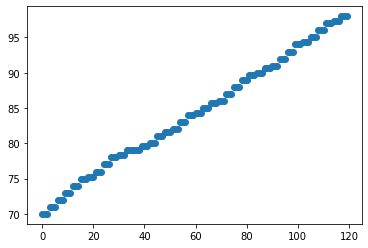

In [12]:
# 資料可能是連續的 要調整
x_axis = np.array(range(len(label)))
plt.scatter(x_axis, label, marker='o')

In [13]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, r2_score




# data_ori = train_test_split(df, label, test_size=0.33, random_state=42)



In [14]:
# import pandas as pd
# a = np.empty((100,100))
# a[:] = np.nan

# df = pd.DataFrame(a)
# df.at[0,0] = 1
# df

In [15]:
def eva_metric(y_true, y_pred):
    dic = {'mse':mean_squared_error,
       'mae': mean_absolute_error,
       'r2_score': r2_score}
    
    r2 = []
    for i in dic.keys():
        score = dic[i](y_true, y_pred)
        print(i, score)
        if i == 'r2_score':
            r2.append(score)
    return r2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.33, random_state=42)

plot = False
dic = {'obj':['reg:squarederror', 'reg:linear'],
       'booster':['gblinear', 'gbtree', 'dart'],
       'max_depth':[4, 8, 12]}

best_lis = []
record_dic = {'obj':[],
              'booster':[],
              'max_depth':[],
              'score':[] }
max_score = 0
for a in dic['obj']:
    for b in dic['booster']:
        for c in dic['max_depth']:
            print(a, b, 'max_depth =', c)
            
            # model training 
            model = xgb_model(500, 'reg:squarederror', 'gbtree', 12)
            model.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    eval_metric='mae', verbose = False)
            
            # model predict and evaulate.
            y_pred = model.predict(X_test)
            y_true = y_test
            r2 = eva_metric(y_true, y_pred)
            
            record_dic['obj'].append(a)
            record_dic['booster'].append(b)
            record_dic['max_depth'].append(c)
            record_dic['score'].append(r2[0])
            
            # record best score
            if r2[0] > max_score:
                max_score = r2[0]
                best_lis.append(a+' '+b+' '+'max_depth ='+str(c))
                
            results = model.evals_result()
            
            # plot lr curve for mae
            if plot:
                lr_curve(results, 'xgb linear', 'learning curve of gblinear')
print(best_lis, max_score)

'''
best 
['reg:squarederror gblinear max_depth =4'] 0.9945255065268811
'''

reg:squarederror gblinear max_depth = 4
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror gblinear max_depth = 8
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror gblinear max_depth = 12
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror gbtree max_depth = 4
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror gbtree max_depth = 8
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror gbtree max_depth = 12
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror dart max_depth = 4
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror dart max_depth = 8
mse 0.3486000964410339
mae 0.36140809377033667
r2_score 0.9945255065268811
reg:squarederror dart max_depth = 12
mse 0.3486000964410339
mae 0.36140809377033667
r2_score

In [ ]:
pd.DataFrame()

In [16]:
dic = {'obj':['reg:squarederror', 'reg:linear'],
       'booster':['gblinear', 'gbtree', 'dart'],
       'max_depth':[4, 8, 12]}
best_lis = []
max_score = 0
for a in dic['obj']:
    for b in dic['booster']:
        for c in dic['max_depth']:
            print(a, b, 'max_depth =', c)
            y_true, y_pred = xgb_test(data_ori, 500, False, a, b, max_depth = c)
            

            r2 = eva_metric(y_true, y_pred)
            if r2[0] > max_score:
                max_score = r2[0]
                best_lis.append(a+' '+b+' '+'max_depth ='+str(c))
print(best_lis, max_score)

'''
best reg:squarederror gblinear max_depth = 4 
reg:squarederror gblinear max_depth = 4
mse 27.953177039845684
mae 3.9668374506632573
r2_score 0.561017088578295
'''

In [17]:
# print(best_lis[-1])
# max_score

In [18]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, 
               coef0=1, verbose = True)

dic = {'svr_model':[svr_rbf, svr_lin]} # poly 跑很久 沒再動

In [19]:
# df, label = get_data()
# data_ori = train_test_split(df, pd.DataFrame(label), test_size=0.33, random_state=42)
# X_train, X_test, y_train, y_test = data_dec(data_ori)

# y_train = np.array(y_train)
# y_train = np.squeeze(y_train, axis = -1)


# for model in dic['svr_model']:
#     print(model)
#     model.fit(X_train, y_train)
#     y_true = y_test.values
#     y_pred = model.predict(X_test)
    
#     eva_metric(y_true, y_pred)
#     print('\n')

In [20]:
def sig_disturb(data2func, percent):
    percent = percent
    y = data2func.copy()
    np.random.seed(1)

    nums = int(len(y)/100*percent)
    if nums == 0:
        nums = 1
    rand = np.random.choice(range(len(y)), nums, replace=False)
    noise = []
    for i in y[rand]:
        a = np.random.normal(loc=i, scale=y.std())
        noise.append(a)
    noise = np.array(noise)
    noise *= 0.01
    y[rand] += noise
    return y, rand

8.017064433372823
8.123171899843314


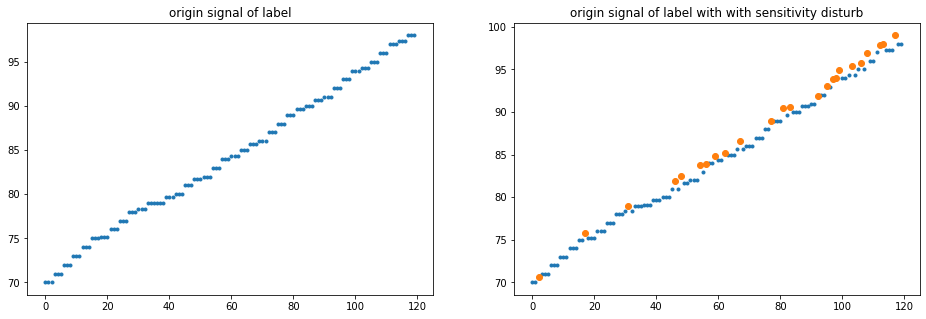

In [21]:
# 雜訊
df_disturb, label = get_data()
# add noise on dirt 

print(label.std())
x_axis = np.array(range(len(label)))


# add noise
noise_label, rand= sig_disturb(label, 20)
print(noise_label.std())

# plot
fig=plt.figure(figsize = (16, 5))

fig_place = [1,2]

subplot1 = fig.add_subplot(fig_place[0], fig_place[1], 1)
plt.scatter(x_axis, label, marker='.')
plt.title("origin signal of label", y=1)

subplot2 = fig.add_subplot(fig_place[0], fig_place[1], 2)
plt.title("origin signal of label with with sensitivity disturb")
plt.scatter(x_axis, noise_label, marker='.')
plt.scatter(x_axis[rand], noise_label[rand], marker='o')

In [22]:
# disturb training
data_ori = train_test_split(df_disturb, pd.DataFrame(noise_label), test_size=0.33, random_state=42)


print('train xgb with squarederror, gbtree')
y_true, y_pred = xgb_test(data_ori, 500, False, 'reg:squarederror', 'gbtree', max_depth = 12)
eva_metric(y_true, y_pred)

X_train, X_test, y_train, y_test = data_dec(data_ori)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
model = svr_lin
y_train = np.array(y_train)
y_train = np.squeeze(y_train, axis = -1)
print('\ntrain svm with linear')
model.fit(X_train, np.array(y_train))

y_true = y_test.values
y_pred = model.predict(X_test)
eva_metric(y_true, y_pred)


train xgb with squarederror, gbtree
mse 0.3878920130645943
mae 0.4468362046590862
r2_score 0.9939416947213084

train svm with linear
mse 0.513275304859272
mae 0.5847653554612933
r2_score 0.9919833912941818


[0.9919833912941818]

In [23]:
def sig_transmittion_noise(data2func, percent):
    percent = percent
    y = data2func.copy()
    np.random.seed(1)

    nums = int(len(y)/100*percent)
    if nums == 0:
        nums = 1
    rand = np.random.choice(range(len(y)), nums, replace=False)
#     noise = np.ones(nums)
#     noise*=1000
    y[rand] = 1000
    
    return y, rand


8.017064433372823
368.26362915703874


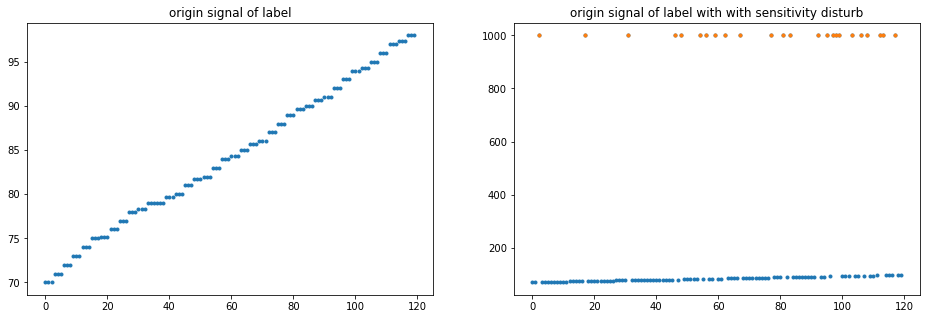

In [24]:
# 雜訊
df_noise, label = get_data()
# add noise on dirt 

print(label.std())
x_axis = np.array(range(len(label)))


# add noise
noise_label, rand= sig_transmittion_noise(label, 20)
print(noise_label.std())

# plot
fig=plt.figure(figsize = (16, 5))

fig_place = [1,2]

subplot1 = fig.add_subplot(fig_place[0], fig_place[1], 1)
plt.scatter(x_axis, label, marker='.')
plt.title("origin signal of label", y=1)

subplot2 = fig.add_subplot(fig_place[0], fig_place[1], 2)
plt.title("origin signal of label with with sensitivity disturb")
plt.scatter(x_axis, noise_label, marker='.')
plt.scatter(x_axis[rand], noise_label[rand], marker='.')

In [25]:
# 在訓練資料中會遇到雜訊突波 但在測試資料集上不應該有(因為那是我們的預測目標) 
# 在訓練集上filter離群值後訓練 預測就不會受離群值影響
df, label = get_data()
data_ori = train_test_split(df, label, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = data_dec(data_ori)

train = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)
# y_train = train.pop('dirt')

noise_label, _= sig_transmittion_noise(train['dirt'], 20)
train.loc[_, 'dirt'] = 1000
arr = train['dirt'].values
thres = arr.mean() + arr.std()
outlier_filter = np.array(arr<thres)

X_clean = train[outlier_filter]
y_clean = X_clean.pop('dirt')

mse 1.9778875996778091
mae 1.0375699129971545
r2_score 0.9456558651299503


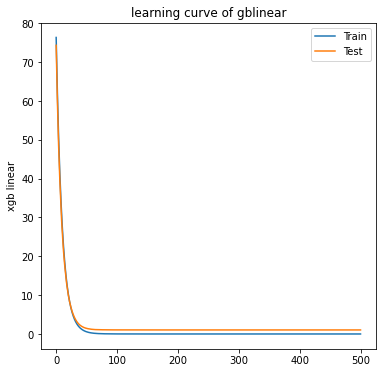

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.33, random_state=42)



model = xgb_model(500, 'reg:squarederror', 'gbtree', 12)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae', verbose = False)
y_pred = model.predict(X_test)
y_true = y_test
eva_metric(y_true, y_pred)

results = model.evals_result()
if True:
    lr_curve(results, 'xgb linear', 'learning curve of gblinear')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.33, random_state=42)

print('train svm with linear')

svr_lin = SVR(kernel='linear', C=100, gamma='auto')
model = svr_lin
y_train = np.array(y_train)
model.fit(X_train, np.array(y_train))

y_true = y_test
y_pred = model.predict(X_test)
eva_metric(y_true, y_pred)

train svm with linear
mse 0.2795885174321655
mae 0.44052895290119665
r2_score 0.9923180689833305


[0.9923180689833305]